# Training Data

The training data is generated using real HSC images from the Ultra Deep (UD) field. The ground truth source detection masks are generated using the [scarlet](https://github.com/pmelchior/scarlet) deblender. HSC UD data can be accessed from https://hsc-release.mtk.nao.ac.jp/doc/index.php/tools-2/. We used the public DR2 UD stacks from: https://hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results. The HSC DR2 data is described in [Hiroaki et al. 2019](https://ui.adsabs.harvard.edu/abs/2019PASJ...71..114A/abstract).

In [1]:
# In case you need to point to pre-existing scarlet install
import sys
sys.path.insert(1, '/home/paleo2/.conda/envs/astro-det-scarlet2/lib/python3.7/site-packages/scarlet-1.0.1+gfde109a-py3.7-linux-ppc64le.egg/')

In [2]:
# Standard imports
import sys, os
import numpy as np
import time
import glob

import scarlet
import sep

import astropy.io.fits as fits
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
from astropy.coordinates import SkyCoord

from scarlet.display import AsinhMapping
from astropy.nddata import Cutout2D

# Astrodet imports
import astrodet.scarlet as sc
from astrodet.hsc import get_tract_patch_from_coord, get_hsc_data

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib
import matplotlib.pyplot as plt

# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gray', interpolation='none', origin='lower')

In [3]:
# Print the versions to test the imports and so we know what works
print(scarlet.__version__)
print(np.__version__)
print(sep.__version__)

1.0.1+gfde109a
1.20.2
1.1.1


### Test Scarlet

First, let's test scarlet using one HSC UD image. The HSC image data is divided into "tracts" and "patches" on the sky. You can get the HSC image data given any ra, dec using the code below.

View HSC tract maps: https://hsc-release.mtk.nao.ac.jp/doc/index.php/data/

In [4]:
filters = ['g', 'r', 'i']

# Input coordinate
c = SkyCoord(151.3816, 2.5854, unit='deg')

def generate_training_data_example(c, plot_image=False, plot_stretch_Q=False, plot_scene=True,
                                   plot_likelihood=False, write_results=False, cutout_size=[1024, 1024]):
    """
    Parameters
    ----------
    c : SkyCoord object
          The ra, dec pointing (single or lists of pointings)
    plot_image : bool
          Whether or not to plot the image
    plot_stretch_Q : bool
          Whether or not to plot different normalizations of your image using the stretch, Q parameters.
    plot_scene : bool
           Whether or not plot scene with scarlet
    plot_likelihood : bool
           Whether or not plot the log likelihood of the scarlet fitting
    write_results : bool
          Whether or not to write results to FITS file
    cutout_size : [int, int]
          Cutout shape of image
          
    Returns
    -------
    The scarlet image test in FITS files.
    
    """
    
    # Get the tract, patch
    tract, patch = get_tract_patch_from_coord(c)
    print('\nTract, patch from coord:', tract, patch, "\n")

    # Point to the HSC data directory
    hsc_dirpath = '/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/'

    # Get the HSC data from the file info
    # If you want a cutout centered a coordinate, you must pass the coord argument directly into get_hsc_data
    # Otherwise, you can provide patch and tract and the cutout will be centered on the patch image center

    # Warning: Wall time is O(N^3), where N is the image length or width
    datas = get_hsc_data(dirpath=hsc_dirpath, filters=filters, coord=c, cutout_size=cutout_size)

    # Plot image data
    if plot_image:
        fig, ax = plt.subplots(1, 1, figsize=(9,9))
        norm = scarlet.display.AsinhMapping(minimum=0, stretch=1, Q=5)
        img_rgb = scarlet.display.img_to_rgb(datas, norm=norm)
        ax.imshow(img_rgb)
        ax.axis('off')

    # Find good stretch and Q
    if plot_stretch_Q: fig = sc.plot_stretch_Q(datas);

    ### Run scarlet on image ###

    # HSC pixel scale in arcsec/pixel
    ps = 0.17
    # Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
    print(f'\nsigma_obs: {np.around(sigma_obs, 2)} pixels.')

    # Run Scarlet
    out = sc.run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=plot_scene,
                         max_chi2=1000000, morph_thresh=0.001, starlet_thresh=0.01, stretch=1, Q=5, 
                         plot_wavelet=False, plot_likelihood=plot_likelihood, plot_sources=False, add_ellipses=True,
                         add_labels=False, add_boxes=False, lvl_segmask=2)

    # Unpack output
    observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out

    # Save Scarlet data to FITS file
    if write_results:
        filenames = sc.write_scarlet_results(datas, observation, starlet_sources, model_frame, 
                                             catalog_deblended, segmentation_masks, dirpath='.', 
                                             filters=filters, tract=tract, patch=patch)
    
        print(f'\nSaved scarlet results as {filenames} \n')


Tract, patch from coord: 9814 (6, 6) 

Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-G/9814/6,6/calexp-HSC-G-9814-6,6.fits".


/home/colinjb2/astrodet/astrodet/hsc.py:85: UserWarning: Overriding tract/patch info and looking for HSC file at requested coordinates.
  warnings.warn("Overriding tract/patch info and looking for HSC file at requested coordinates.")


Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-R/9814/6,6/calexp-HSC-R-9814-6,6.fits".
Loading "/home/paleo2/ASTRODET/HSC/hsc-release.mtk.nao.ac.jp/archive/filetree/pdr2_dud/deepCoadd-results/HSC-I/9814/6,6/calexp-HSC-I-9814-6,6.fits".

sigma_obs: 2.0 pixels.
Source catalog found  137 objects
Initializing starlet sources to be fit.
Fitting Blend model.
Scarlet ran for 23 iterations to logL = -728269.4704891151


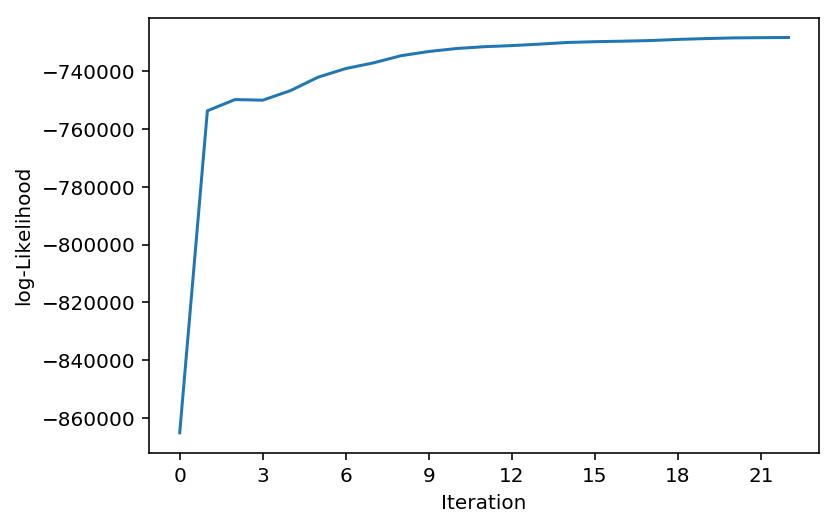

Computing residuals.
Extracting deblended catalog.


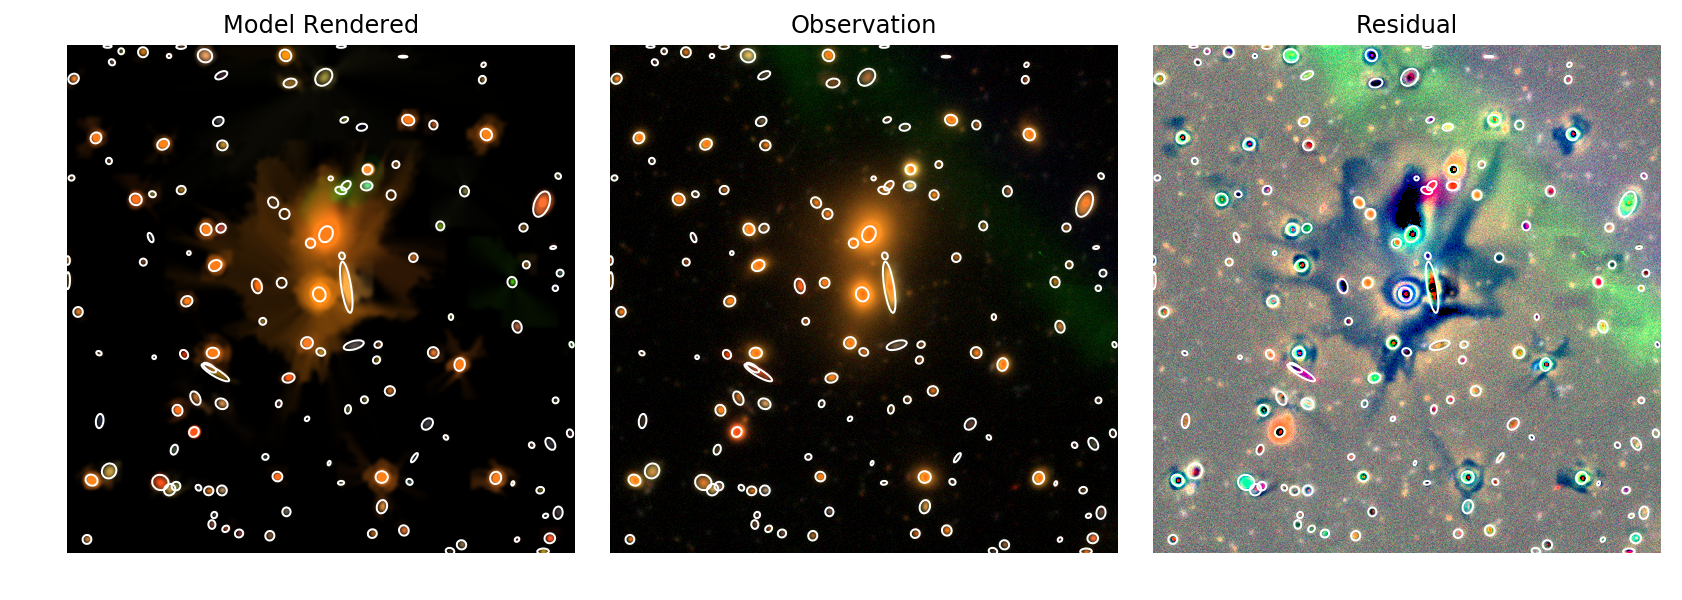


Saved scarlet results as {'img_G': './calexp-HSC-G-9814-6,6_scarlet_img.fits', 'model_G': './calexp-HSC-G-9814-6,6_scarlet_model.fits', 'img_R': './calexp-HSC-R-9814-6,6_scarlet_img.fits', 'model_R': './calexp-HSC-R-9814-6,6_scarlet_model.fits', 'img_I': './calexp-HSC-I-9814-6,6_scarlet_img.fits', 'model_I': './calexp-HSC-I-9814-6,6_scarlet_model.fits', 'segmask': './calexp-HSC-9814-6,6_scarlet_segmask.fits'} 

CPU times: user 1min 38s, sys: 1.31 s, total: 1min 39s
Wall time: 1min 35s


In [5]:
%%time

generate_training_data_example(c=c, plot_scene=True, plot_likelihood=True, cutout_size=[512, 512], write_results=True)

### Crowded Field Examples

Let's show a few more examples in some crowded fields we chose by eye. We can use multiprocessing to speed-up the results.

In [23]:
import multiprocessing
from itertools import repeat

processes = 20

In [ ]:
ras = [149.9234, 149.8460, 149.9244, 150.4154, 151.2481, 150.1958, 148.4212, 150.7502]
decs = [3.0282, 2.8791, 3.0290, 2.4298, 1.8747, 1.6495, 1.5768, 2.3446]

examples_coords = SkyCoord(ras, decs, unit='deg')

# Arguments for generate_training_data_example
plot_image = False
plot_stretch_Q = False
plot_scene = True,
plot_likelihood = False
write_results = False
cutout_size = [128, 128]

args = zip(examples_coords, repeat(plot_image), repeat(plot_stretch_Q), repeat(plot_scene),
           repeat(plot_likelihood), repeat(write_results), repeat(cutout_size))
    
# Pool each image to a CPU
with multiprocessing.Pool(processes=processes) as pool:
    results = pool.starmap(generate_training_data_example, args)

### Generate training data

Now that we are satisfied with the results, let's split the tracts and patches into a test, training, and validation datatset. Then, we will split up each 4K CCD into a $1024 x 1024$ pixel image and run scarlet in the usual fashion.

In [ ]:
def generate_training_data(dirpath, filters=['g','r','i'], ratios=[1, 0.2, 0.2], processes=20):
    
    """
    Description.
    
    
    
    """
    
    import glob
    import multiprocessing
    
    dirpath_write = os.path.join(dirpath, 'training_data')
    
    # HSC pixel scale in arcsec/pixel
    ps = 0.17
    # Approximate PSF size in UD field according to HSC DR2 paper is 0.8 arcsec
    sigma_obs = gaussian_fwhm_to_sigma*0.8/ps
        
    # Normalize ratios to sum to 1
    ratios = ratios / np.sum(ratios)
    
    # Get all HSC data
    files = []
    f = filters[0]
    f = f.upper()
    
    files = glob.glob(os.path.join(dirpath, f'HSC-{f}/**/**/calexp-HSC-{f}-*.fits.gz'), recursive=True)
    # Randomize file order
    np.random.shuffle(files)
            
    # Split dataset into training, validation, and test using ratios
    ln = len(files)
    i_train = int(np.floor(ln*ratios[0]))
    i_val = int(np.floor(ln*ratios[1]))
    i_test = int(np.floor(ln*ratios[1]))
    
    # Split using index
    files_val = files[:i_val]
    files_test = files[i_val:i_val + i_test]
    files_train = files[i_val + i_test:]
    
    def _run_scarlet_training():

        s = fi.split(f'calexp-HSC-{f}-')[1].split('.fits.gz')[0]
        tract, patch = s.split('-')
        patch = tuple(map(int, patch.split(',')))

        # Run Scarlet
        out = sc.run_scarlet(datas, filters, sigma_model=1, sigma_obs=sigma_obs, plot_scene=plot_scene,
                             max_chi2=1000000, morph_thresh=0.001, starlet_thresh=0.01, stretch=1, Q=5, 
                             plot_wavelet=False, plot_likelihood=plot_likelihood, plot_sources=False, add_ellipses=True,
                             add_labels=False, add_boxes=False)

        # Unpack output
        observation, starlet_sources, model_frame, catalog, catalog_deblended, segmentation_masks = out

        filenames = sc.write_scarlet_results(datas, observation, starlet_sources, model_frame, 
                                         catalog_deblended, segmentation_masks, dirpath='.', 
                                         filters=filters, tract=tract, patch=patch)

        print(f'\nSaved scarlet results as {filenames} \n')
    
    # Run scarlet on training and test datasets
    for i, f in enumerate([files_train, files_test]):
        
        # Pool each image to a CPU
        with multiprocessing.Pool(processes=processes) as pool:
            results = pool.starmap(_run_scarlet_training, f)
        
    return files_train, files_val, files_test